In [1]:
import pyvista as pv
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sys
np.random.seed(0)

import mesh_laplacian
# for now I'm using global variables rather than externally defined functions

In [2]:
# with animated plotting
def step_se(u, v, a, b, nsteps=1):
    """
    Steps morphogen concentrations u and v forwards in time
    according to the system equations (SE).
    """
    
    for i in range(nsteps):
        # nonlinear reaction terms
        # for u: u(n)*u(n+1)*v(n)
        u_nonlin = sp.eye(nx)
        u_nonlin.setdiag(u*v)

        # for v: u(n)^2*v(n+1)
        v_nonlin = sp.eye(nx)
        v_nonlin.setdiag(u**2)


        # linear operators for gmres
        A_u = iden - dt*( du*lap/dx**2 - g*iden + g*u_nonlin )
        b_u = u + dt*g*a

        A_v = iden - dt*( dv*lap/dx**2 - g*v_nonlin )
        b_v = v + dt*g*b


        # Run GMRES to solve for next timestep
        u, info_u = sp.linalg.gmres(A_u, b_u, maxiter=1000)
        v, info_v = sp.linalg.gmres(A_v, b_v, maxiter=1000)

        
        # Should catch a convergence failure here using info_u and info_v
        if info_u>0 or info_v>0:
            print("Warning: GMRES convergence failed")
            
    return u, v

def eval_j(u, v, ut, vt, c1, c2, g1, g2, d1, d2):
    """
    Evaluates the objective functional J.
    """
    
    j = np.sum(g1*(u-ut)**2 + g2*(v-vt)**2)*dx + d1*c1**2 + d2*c2**2 
    j*= 0.5
    
    return j


def descend_c(u_t, v_t, c1, c2, l, ltol):
    '''Find optimal c1, c2 by descending gradient of J'''
    
    # initialize storage arrays
    c1_stored, c2_stored = [c1], [c2]
    
    # solve SE for one step, starting at target
    u1, v1 = step_se(u_t, v_t, c1, c2)

    # evaluate cost after this timestep
    j1 = eval_j(u1, v1, u_t, v_t, c1, c2, g1, g2, d1, d2)


    for i in range(niter):

        # step c1, c2 and evaluate cost gradient
        increment = 1e-12 # should be less than step size
        c1s, c2s = c1+increment, c2+increment

        u1s1, v1s1 = step_se(u_t, v_t, c1s, c2)
        u1s2, v1s2 = step_se(u_t, v_t, c1, c2s)

        j1s1 = eval_j(u1s1, v1s1, u_t, v_t, c1s, c2, g1, g2, d1, d2)
        j1s2 = eval_j(u1s2, v1s2, u_t, v_t, c1, c2s, g1, g2, d1, d2)

        jgrad = ((j1s1-j1)/increment, (j1s2-j1)/increment)

        # step both in direction opposite to gradient
        c1_new = c1-l*jgrad[0]
        c2_new = c2-l*jgrad[1]

        # test whether j actually decreased;
        # if not then change step size and do again
        # if yes then update c1, c2

        u1_new, v1_new = step_se(u_t, v_t, c1_new, c2_new)
        j1_new = eval_j(u1_new, v1_new, u_t, v_t, c1_new, c2_new, g1, g2, d1, d2)
        
        # print(j1, j1_new)

        if j1_new > j1:
            l /= 10

        else:
            l *= 3/2
            c1, c2 = c1_new, c2_new
            u1, u2 = u1_new, v1_new
            j1 = j1_new
            
            c1_stored.append(c1_new); c2_stored.append(c2_new)
            
            if l<ltol:
                print('convergence to optimal solution reached in {} iterations'.format(i))
                break


        # print("step size: {:.2e}".format(l))
        # if j1_new < jtol: # I think its better to use a step size convergence criterion

        if i==niter-1: 
            # plt.plot(u1_new)
            print(j1)
            print('failed to converge after {} iterations'.format(niter))

    return c1_stored, c2_stored


In [43]:
# cost parameters
g1, g2 = 1e10, 1e10
d1, d2 = 1, 1

# use steady-state of previous forward problem solution as target function
example = "slow_sphere_3.vtk"
target_mesh = pv.read('examples/data/'+example)
u_t, v_t = target_mesh['u'], target_mesh['v']

# iteration parameters
nx = target_mesh.n_points
niter = 3000
dt = 0.0001
dx = .002/2#*2.5 # good for decimated sphere
# dx = .2 # good for decimated cow


l = 1e-5
niter = 500
jtol = 1e2   # not currently used; I think its better to use step size as convergence criterion
ltol = 1e-12

du = 1
dv = 10
g = 1000 
a_true = 0.126779*0.25
# b_true = 0.792366
b_true = 1.1
# b_true = 1.5
c1, c2 = a_true*1.0, b_true*1.0 # initial guess

iden = sp.eye(nx)
lap = mesh_laplacian.compute_mesh_laplacian(target_mesh)

print("Beginning gradient descent...")
c1_stored, c2_stored = descend_c(u_t, v_t, c1, c2, l, ltol)


print("Error in estimate of a: {:.8f}%".format(100*abs(a_true - c1_stored[-1])/a_true))
print("Error in estimate of b: {:.8f}%".format(100*abs(b_true - c2_stored[-1])/b_true))

print(a_true - c1_stored[-1], b_true - c2_stored[-1])


Beginning gradient descent...
convergence to optimal solution reached in 23 iterations
Error in estimate of a: 1.32441172%
Error in estimate of b: 0.01779878%
0.0004197689830527304 0.00019578659531238607


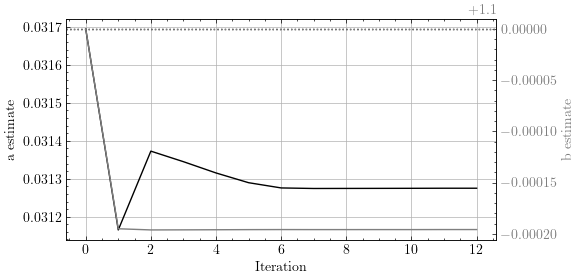

In [44]:
# Plot results
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')

fig, ax1 = plt.subplots(figsize=(6,3))

color = 'k'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('a estimate', color=color)
ax1.plot(c1_stored, color=color)
ax1.axhline(y=a_true, xmin=0, xmax=len(c1_stored), color=color, linestyle=':')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:gray'
ax2.set_ylabel('b estimate', color=color)  # we already handled the x-label with ax1
ax2.plot(c2_stored, color=color)
ax2.axhline(y=b_true, xmin=0, xmax=len(c2_stored), color=color, linestyle=':')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid()
plt.savefig('examples/inverse/'+example[:-4]+'.png', dpi=1200)
plt.show()

